In [1]:
# forcing the notebook to reload the modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import os
from src.data import fontdb_handler as fh
from src.model import helperfunctions as hf
from src.data import datarenderer as dr

2023-11-27 19:34:39.601121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 19:34:39.601231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 19:34:39.601520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 19:34:39.651105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [3]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


2023-11-27 19:34:43.350438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:34:43.368673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:34:43.368713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


## Transfer Learning with CNN on top of EfficientNet

- Input: 
    - 9 or 16 glyphs randomly sampled or hand picked from A-Z, a-z, 0-9, Ä-ß
    - One-Hot vector for the glyph to predict
- Output: 
    - One of the glphy A-Z, a-z, 0-9, Ä-ß (corresponding to the One-Hot vector)

Things to investigate:
- Does the model work better or worse as the CNN model build from scratch?
- What is the minimum number of glyphs in input to get a good accuracy?
- What is the minimum pixel size of the glyphs in input to get a good accuracy?
- Is it better to randomly sample the glyphs for input or to hand pick them?
- What is the best base model to use?

Things to do:
- ~~function getting string of characters and returning sampled glyphs in a quadratic image~~
- creating the training and test data with the One-Hot vectr and the quatraic image from the function above as input, and the corresponding glyph (to the One-Hot vector) as output
- Creating the model
- Training the model while keeping track of the results
- Answering the questions above

In [4]:
training_parameters = {
    "charset_in": "AaOoUu8Bj",
    "charset_out": "Ä",
    "render_size": 64,
    "test_size": 0.1,
    "batch_size": 16
}

In [5]:
PATH_JSON_FONT_DB = '../data/raw/00dataset.json'
font_file_paths = fh.font_file_list(PATH_JSON_FONT_DB) # List with all the paths to the fonts

np.random.seed(42)
font_file_paths = font_file_paths#[:100]
font_file_paths = np.random.permutation(font_file_paths)
num_samples = len(font_file_paths)
num_samples

21314

In [6]:
def create_glyph_grids(chars: str, font_file_paths: list, render_size: int,
                       normalize: bool = False, invert: bool = False, dtype=np.float16):
    """Creates a grid of glyphs from the specified font file paths

    Args:
        chars (str): The characters to render
        font_file_paths (list): List of font file paths
        render_size (int): The size of the rendered glyphs

    Returns:
        np.array: The glyph grid with shape (len(font_file_paths), render_size*num_rows_cols, render_size*num_rows_cols, 1)
    """
    num_rows_cols = int(np.ceil(np.sqrt(len(chars))))
    #num_repeats_last_char = num_rows_cols**2 - len(chars)

    glyph_grid = np.zeros((len(font_file_paths), render_size*num_rows_cols, render_size*num_rows_cols), dtype=dtype)
    if invert:
        rendered_chars_tensor = np.zeros((render_size, render_size, num_rows_cols**2))
    else:
        rendered_chars_tensor = np.ones((render_size, render_size, num_rows_cols**2))
    if not normalize:
        rendered_chars_tensor *= 255
    sketch0 = np.zeros((render_size, render_size, num_rows_cols, num_rows_cols))
    sketch = np.zeros((render_size*num_rows_cols, render_size*num_rows_cols))

    for i, font_file_path in enumerate(font_file_paths):
        rendered_chars_tensor[:,:,:len(chars)] = dr.render_font(font_file_path, render_size, chars,
                                               normalize=normalize, invert=invert, dtype=dtype)
        sketch0 = np.reshape(rendered_chars_tensor,(render_size, render_size, num_rows_cols, num_rows_cols)).transpose(2, 0, 3, 1)
        sketch = np.reshape(sketch0, (render_size*num_rows_cols, render_size*num_rows_cols))
        glyph_grid[i, :, :] = sketch

    return glyph_grid


In [7]:
test_grid = create_glyph_grids("AaOoUu8B", font_file_paths[:2], training_parameters["render_size"])
test_grid.shape

(2, 192, 192)

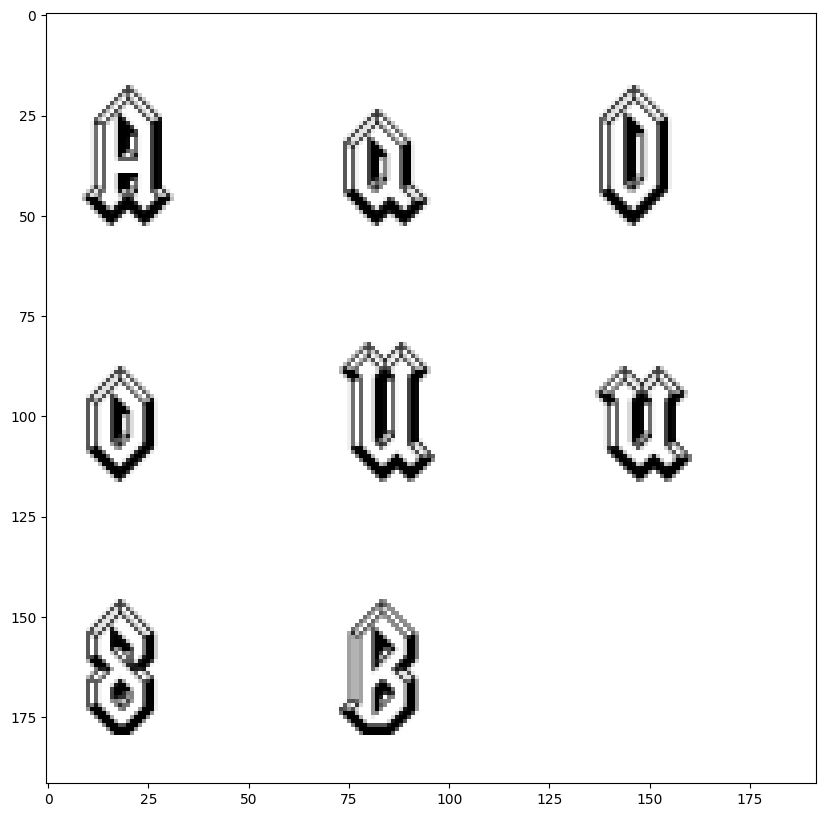

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(test_grid[1, :, :], cmap='gray')


In [9]:
test_grid = np.repeat(test_grid, 3, axis=0)
test_grid.shape

(6, 192, 192)

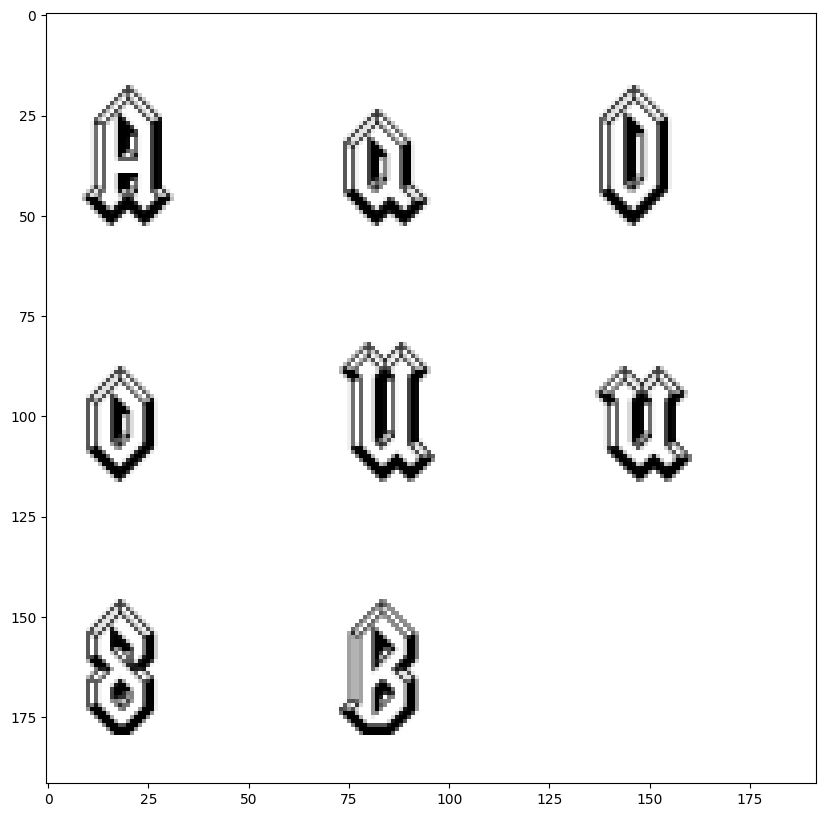

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(test_grid[3, :, :], cmap='gray')

In [11]:
def get_one_hot(char: str, all_chars: str):
    """Returns the one hot vector for the specified character

    Args:
        char (str): The character
        all_chars (str): All characters
        
    Returns:
        np.array: The one hot vector
    """
    return np.eye(len(all_chars))[all_chars.index(char)]

In [12]:
get_one_hot("d", "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789ÄäÖöÜüß")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

## First with hand picked glyphs

### Preparing the data

In [13]:
training_parameters = {
    "charset_in": "AaOoUu8Bj",
    "charset_out": "ÄäÖöÜüß",
    "render_size_in": 64,
    "render_size_out": 64,
    "test_size": 0.1,
    "batch_size": 32
}

In [14]:
def encode(font_file_paths, charset_in, charset_out, render_size_in, render_size_out, num_char_out=None, dtype=np.float16):
    """Encoder for the dataset. Builds pairs of inputs and targets. The input is the rendered glyphs
    from charset_in in a glyph grid and a one hot vector of the character of the target glyph. The target
    is one rendered glyph from charset_out. For all the glyphs in charset_out a pair is created.

    Args:
        font_file_paths (list): List of font file paths
        charset_in (str): The characters to render
        charset_out (str): The characters to render
        render_size_in (int): The size of the rendered glyphs
        render_size_out (int): The size of the rendered glyphs

    Returns:
        tuple ((glyph_grid, one_hot), glyph): The input and target glyph
        with
        glyph_grid (np.array): The glyph grid with shape (len(font_file_paths)*len(charset_out), render_size_in*num_rows_cols, render_size_in*num_rows_cols, 1)
        one_hot (np.array): The one hot vector of the target glyph with shape (len(charset_out))
        glyph (np.array): The target glyph with shape (render_size_out, render_size_out, 1)
    """
    if num_char_out is None or num_char_out == len(charset_out):
        num_char_out = len(charset_out)
    elif num_char_out > len(charset_out):
        raise ValueError("num_char_out must be smaller or equal to len(charset_out)")

    glyph_grid = create_glyph_grids(charset_in, font_file_paths, render_size_in, dtype=dtype)
    glyph_grid = np.repeat(glyph_grid, num_char_out, axis=0)
    one_hot = np.zeros((num_char_out*len(font_file_paths), len(charset_out)), dtype=dtype)
    glyph = np.zeros((num_char_out*len(font_file_paths), render_size_out, render_size_out), dtype=dtype)

    for j, font_file in enumerate(font_file_paths):
        charset_out_list = list(charset_out)
        charset_out_list = np.random.permutation(charset_out_list)
        for i in range(num_char_out):
            char = charset_out_list[i]
            one_hot[i+j*num_char_out, :] = get_one_hot(char, charset_out)
            glyph[i+j*num_char_out, :, :] = dr.render_font(font_file, render_size_out, char, normalize=True)[:,:,0]
    return (glyph_grid, one_hot), glyph
    

In [15]:
encode_test = encode(font_file_paths[:2], 
                     training_parameters["charset_in"], 
                     "ABC", training_parameters["render_size_in"], 
                     training_parameters["render_size_out"],
                     num_char_out=2)
input, target = encode_test
glyp_grid, one_hot = input

glyp_grid.shape, one_hot.shape, target.shape

((4, 192, 192), (4, 3), (4, 64, 64))

[1. 0. 0.]


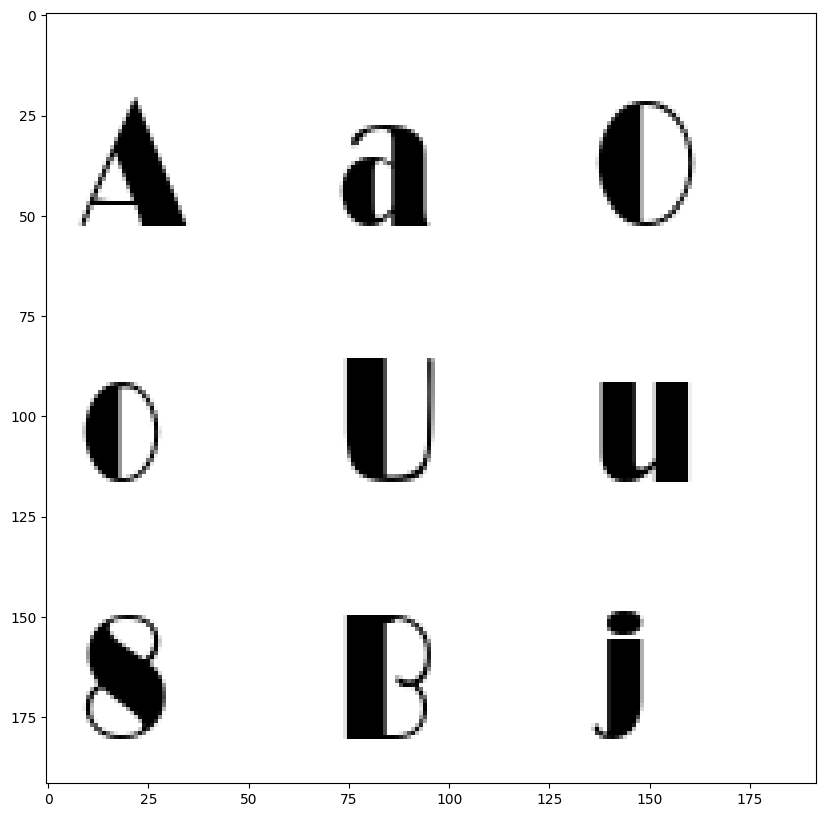

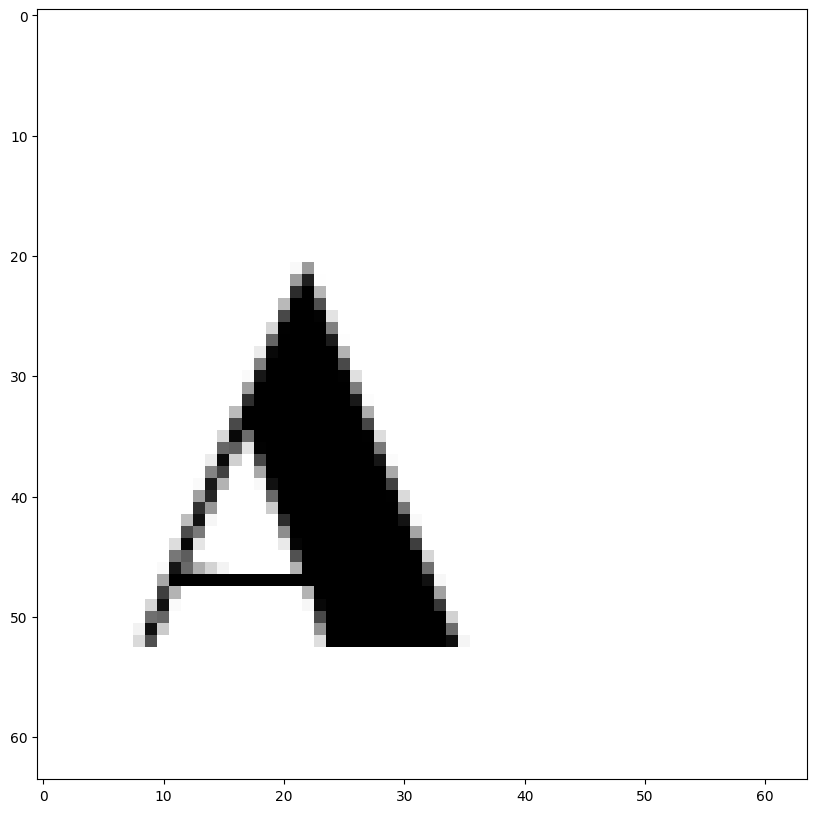

[0. 1. 0.]


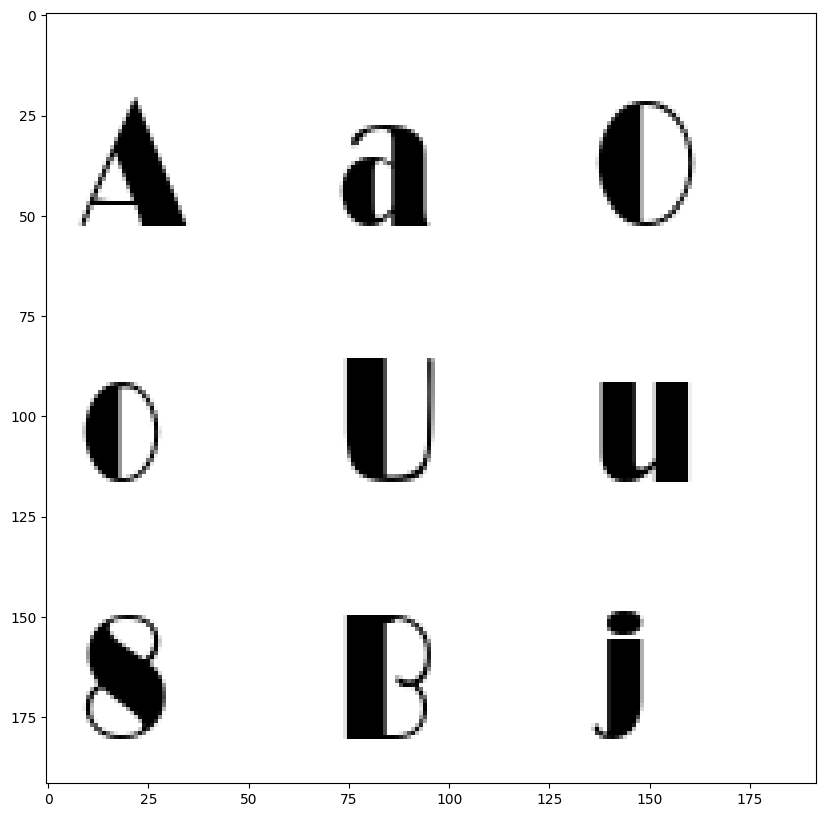

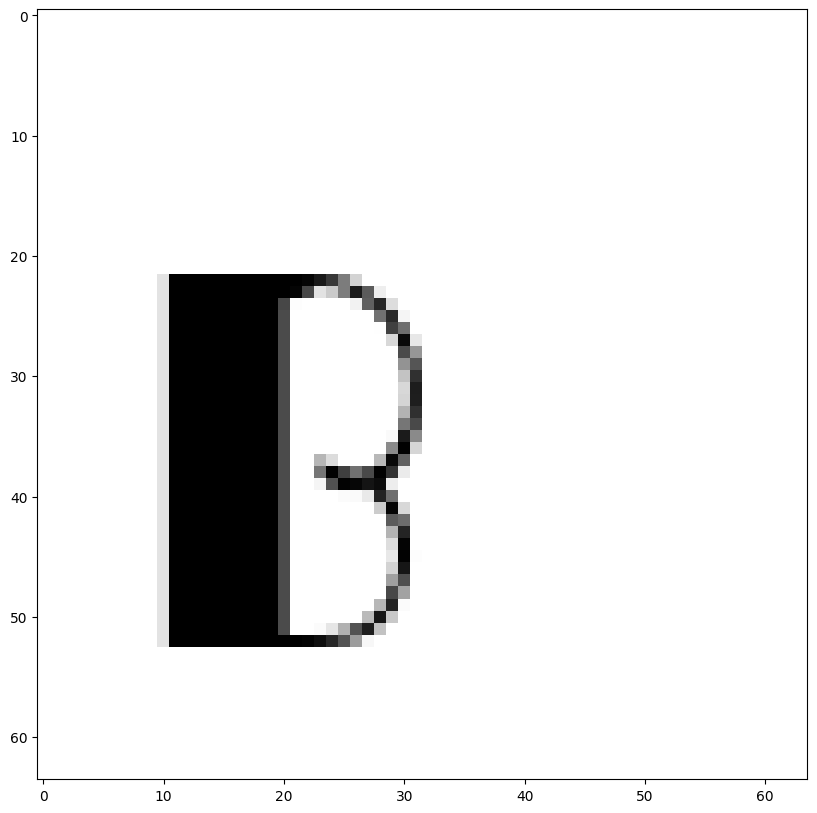

[0. 0. 1.]


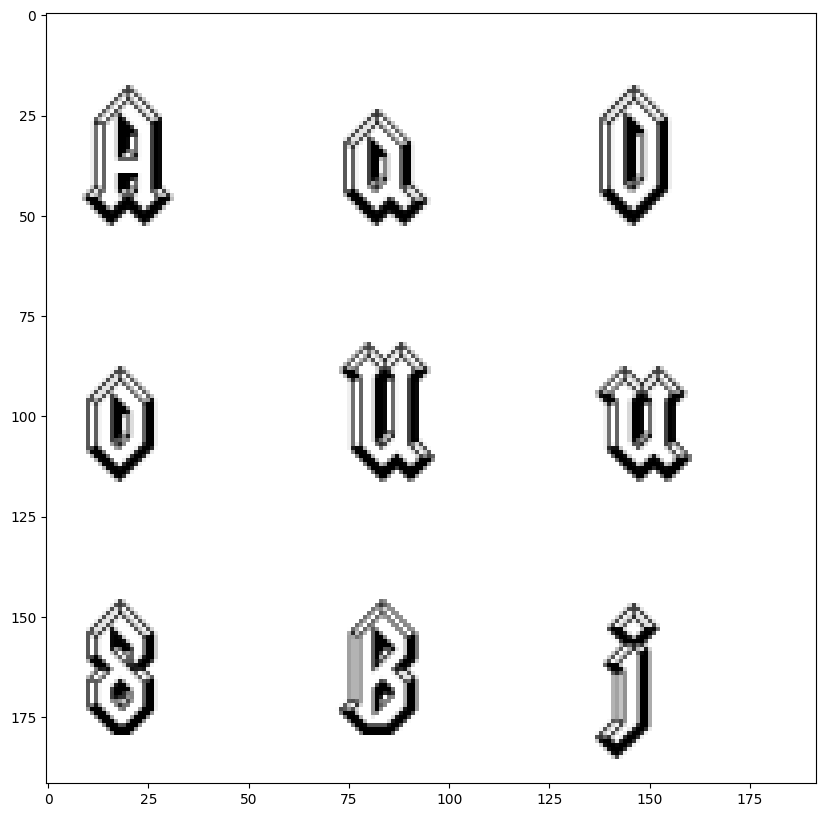

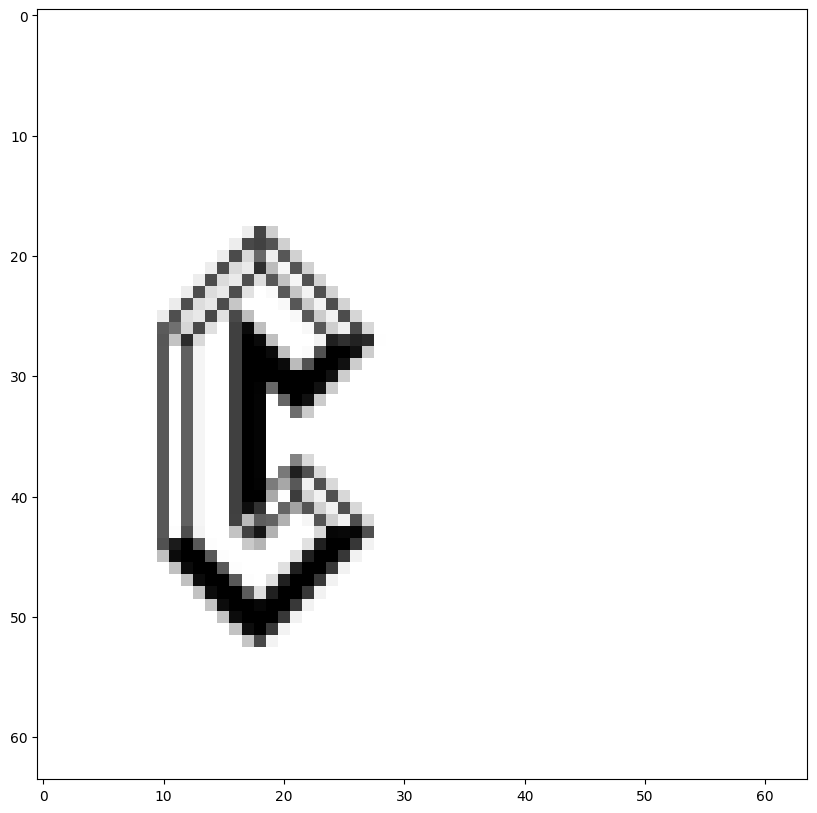

[1. 0. 0.]


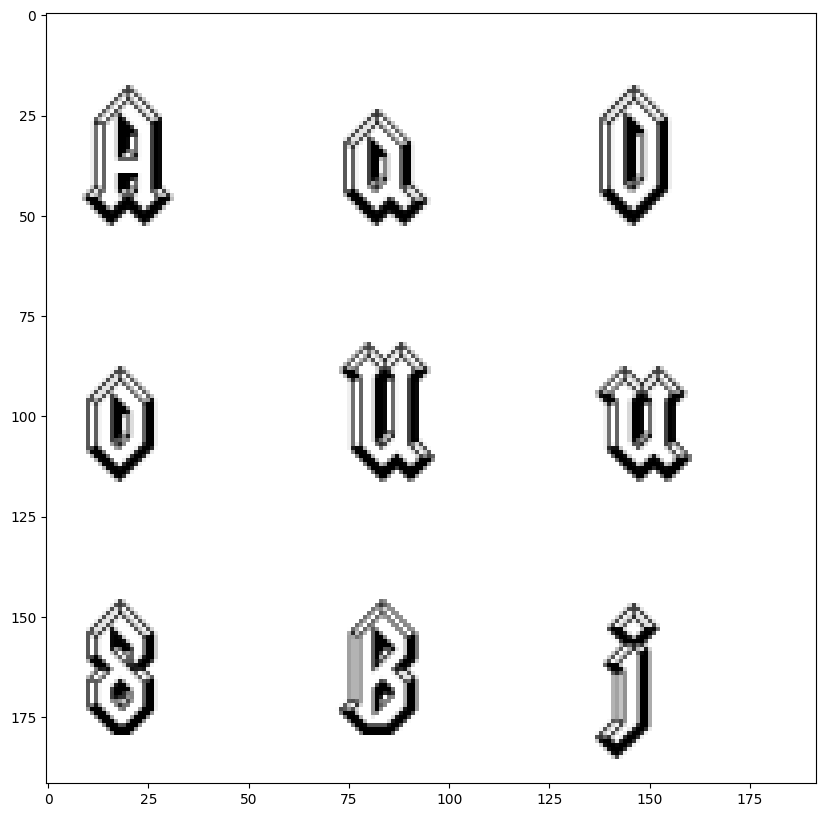

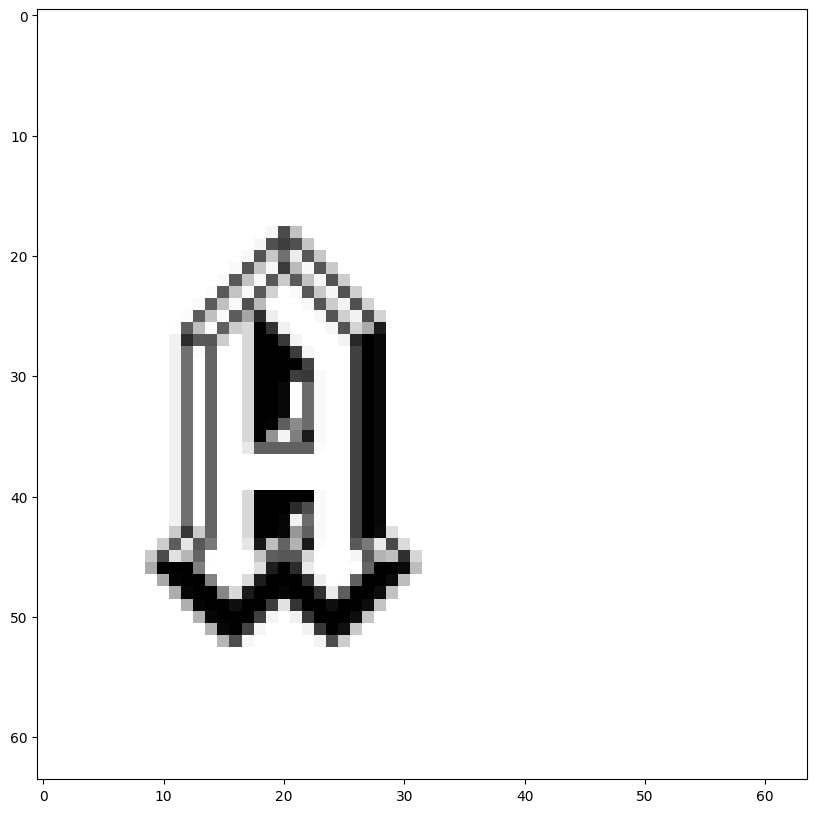

In [16]:
for i in range(len(one_hot)):
    print(one_hot[i])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(glyp_grid[i, :, :], cmap='gray')
    plt.show()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(target[i, :, :], cmap='gray')
    plt.show()
    

In [17]:
num_test_samples = int(num_samples * training_parameters["test_size"])

train_dataset = Dataset.from_tensor_slices(encode(font_file_paths[num_test_samples:], 
                                                  training_parameters["charset_in"], 
                                                  training_parameters["charset_out"], 
                                                  training_parameters["render_size_in"], 
                                                  training_parameters["render_size_out"],
                                                  num_char_out=3))
test_dataset = Dataset.from_tensor_slices(encode(font_file_paths[:num_test_samples], 
                                                 training_parameters["charset_in"], 
                                                 training_parameters["charset_out"], 
                                                 training_parameters["render_size_in"], 
                                                 training_parameters["render_size_out"],
                                                 num_char_out=3))
train_dataset = train_dataset.shuffle(num_samples - num_test_samples).batch(training_parameters["batch_size"])
test_dataset = test_dataset.batch(training_parameters["batch_size"])

2023-11-27 19:35:44.920313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:35:44.920388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:35:44.920410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:35:45.267891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 19:35:45.267937: I tensorflow/compile

In [18]:
train_dataset.element_spec, test_dataset.element_spec

(((TensorSpec(shape=(None, 192, 192), dtype=tf.float16, name=None),
   TensorSpec(shape=(None, 7), dtype=tf.float16, name=None)),
  TensorSpec(shape=(None, 64, 64), dtype=tf.float16, name=None)),
 ((TensorSpec(shape=(None, 192, 192), dtype=tf.float16, name=None),
   TensorSpec(shape=(None, 7), dtype=tf.float16, name=None)),
  TensorSpec(shape=(None, 64, 64), dtype=tf.float16, name=None)))

(32, 192, 192) (32, 7) (32, 64, 64)


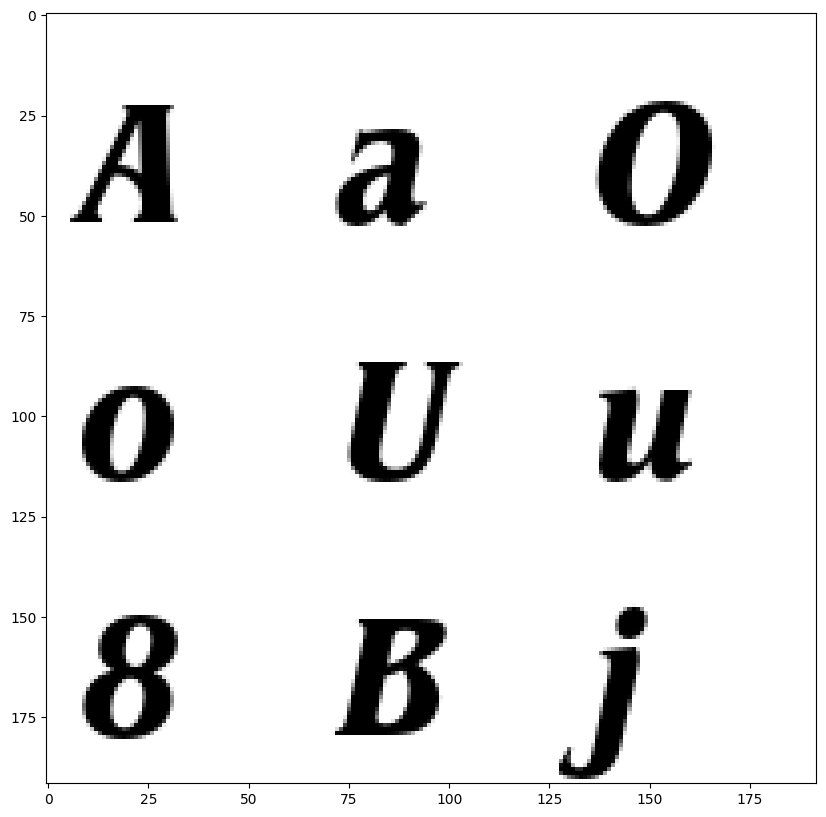

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float16)


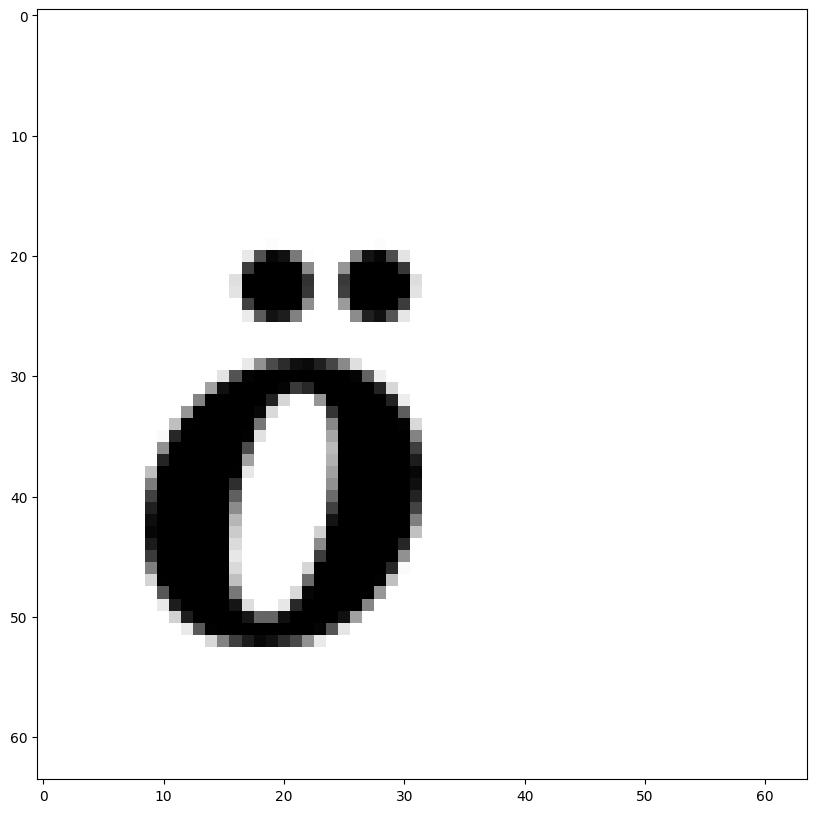

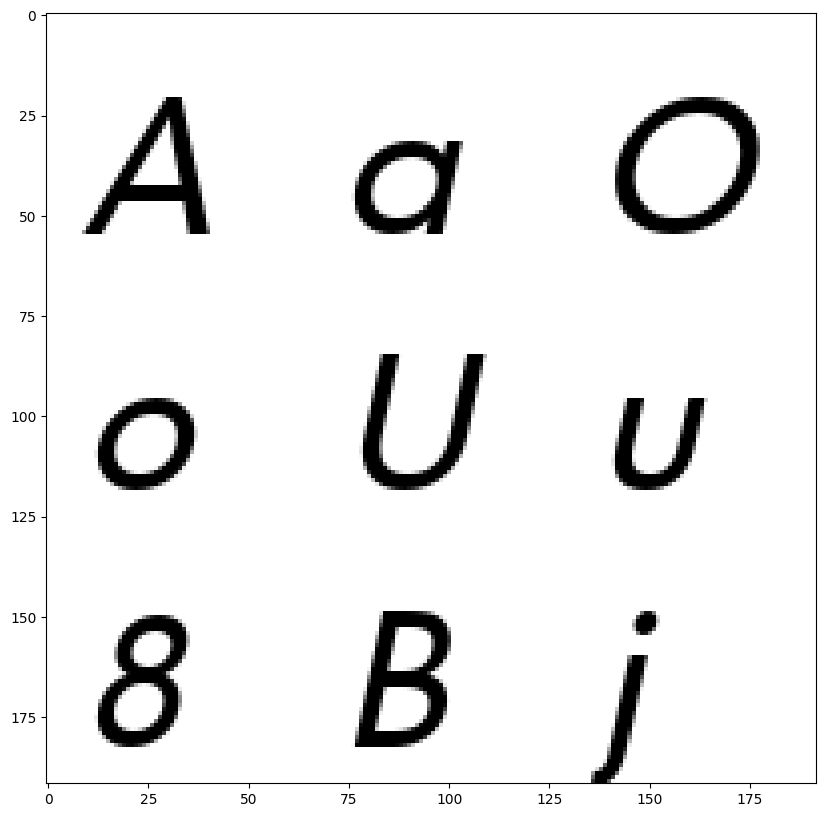

tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float16)


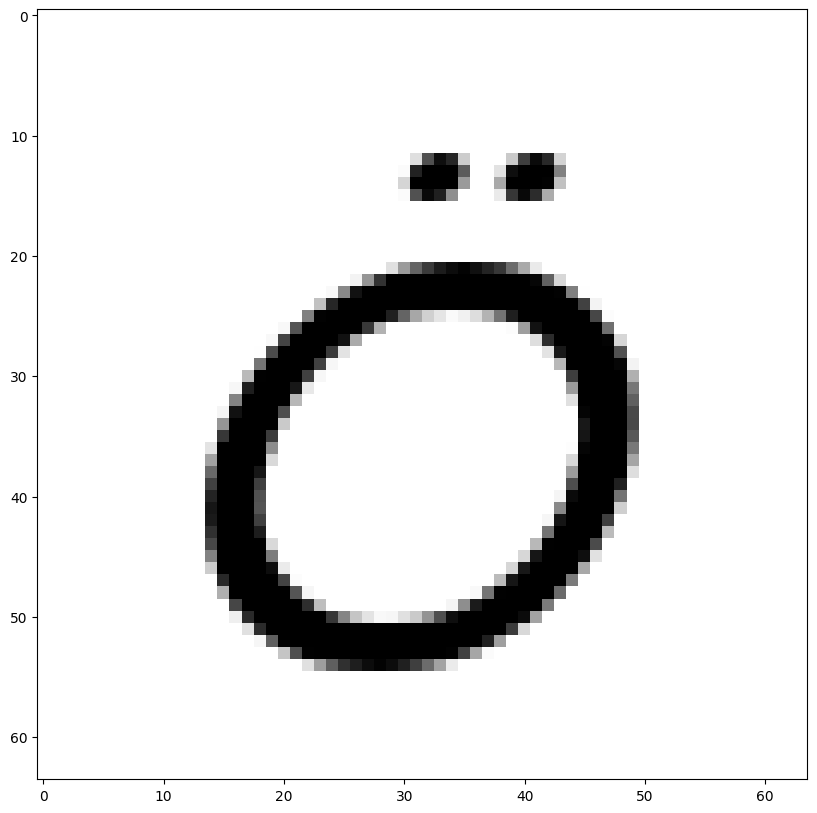

In [19]:
for input, target in train_dataset.take(1):
    print(input[0].shape, input[1].shape, target.shape)
    for i in range(2):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(input[0][i, :, :], cmap='gray')
        plt.show()
        print(input[1][i])
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(target[i, :, :], cmap='gray')
        plt.show()

In [27]:
input_size = training_parameters["render_size_in"] * int(np.ceil(np.sqrt(len(training_parameters["charset_in"]))))
if input_size < 32:
    raise ValueError("EfficientNetB0 requires input size to be at least 32x32")

base_model = tf.keras.applications.EfficientNetB0(input_shape=(input_size, input_size, 3), include_top=False)
base_model.trainable = False

class AutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim, base_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.latent_dim = latent_dim
        self.base_model = base_model

        # Encoder
        self.encoder_flatten = layers.Flatten()
        self.encoder_fc1 = layers.Dense(512, activation="relu")
        self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

        # Decoder
        self.decoder_fc1_one_hot = layers.Dense(512, activation="relu")
        self.decoder_fc1_latent = layers.Dense(512, activation="relu")
        self.decoder_fc2 = layers.Dense(512, activation="relu")
        self.decoder_reshape = layers.Reshape((4, 4, 32))
        #self.decoder_upsample_1 = layers.UpSampling2D((2, 2))
        self.decoder_conv2d_1 = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same", strides=(2, 2))
        #self.decoder_upsample_2 = layers.UpSampling2D((2, 2))
        self.decoder_conv2d_2 = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same", strides=(2, 2))
        #self.decoder_upsample_3 = layers.UpSampling2D((2, 2))
        self.decoder_conv2d_3 = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides=(2, 2))
        self.decoder_conv2d_4 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu")
        self.decoder_out = layers.Conv2DTranspose(1, (3, 3), padding="same")#, activation="sigmoid")
        self.inverter_layer = lambda x: 1. - x

        self._build_graph()

    def call(self, inputs):
        img, one_hot = inputs
        z = self.encode(img)
        y = self.decode(z, one_hot)
        return y
    
    def _build_graph(self):
        img_input_shape = (input_size, input_size)
        one_hot_input_shape = (len(training_parameters["charset_out"]),)
        # Build the model by calling it
        self.build([(None,) + img_input_shape, (None,) + one_hot_input_shape])
        # Create dummy inputs of the correct shape
        img_input = tf.keras.Input(shape=img_input_shape)
        one_hot_input = tf.keras.Input(shape=one_hot_input_shape)
        
        # Use these inputs to build the model
        _ = self.call([img_input, one_hot_input])


    def encode(self, img):
        img = tf.expand_dims(img, axis=-1)  # Add a channel dimension
        img = tf.image.grayscale_to_rgb(img)  # Convert grayscale to RGB
        encoded = self.base_model(img)
        encoded = self.encoder_flatten(encoded)
        encoded = self.encoder_fc1(encoded)
        encoded = self.encoder_fc2(encoded)
        return encoded

    def decode(self, z, one_hot):
        decoded_one_hot = self.decoder_fc1_one_hot(one_hot)
        decoded_latent = self.decoder_fc1_latent(z)
        decoded = tf.keras.layers.add([decoded_one_hot, decoded_latent]) #multiply([decoded_one_hot, decoded_latent])
        decoded = self.decoder_fc2(decoded + decoded_latent)
        decoded = self.decoder_reshape(decoded)
        #decoded = self.decoder_upsample_1(decoded)
        decoded = self.decoder_conv2d_1(decoded)
        #decoded = self.decoder_upsample_2(decoded)
        decoded = self.decoder_conv2d_2(decoded)
        #decoded = self.decoder_upsample_3(decoded)
        decoded = self.decoder_conv2d_3(decoded)
        decoded = self.decoder_conv2d_4(decoded)
        decoded = self.decoder_out(decoded)
        decoded = self.inverter_layer(decoded)
        return decoded


In [28]:
model = AutoEncoder(256, base_model)

model.compile(
    optimizer = "adam",
    loss = "mse"
)

model.summary()

Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 6, 6, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               23593472  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 512)               4096      
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                    

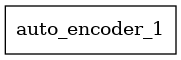

In [29]:
# Showing the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
if "trainings_list" not in locals():
    trainings_list = []

In [31]:
trainings_list.append({
    # getting all the keys and values from the training_parameters dict and adding them to the training dict
    **training_parameters,
    "history": model.fit(
        train_dataset,
        epochs=10,
        validation_data=test_dataset,
)})

Epoch 1/10


2023-11-27 19:45:44.101512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inauto_encoder_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1799/1799 [==============================] - 94s 49ms/step - loss: 0.0364 - val_loss: 0.0320
Epoch 2/10
1799/1799 [==============================] - 88s 49ms/step - loss: 0.0296 - val_loss: 0.0275
Epoch 3/10
1799/1799 [==============================] - 87s 48ms/step - loss: 0.0275 - val_loss: 0.0271
Epoch 4/10
1799/1799 [==============================] - 88s 49ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 5/10
1799/1799 [==============================] - 88s 49ms/step - loss: 0.0253 - val_loss: 0.0259
Epoch 6/10
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0246 - val_loss: 0.0241
Epoch 7/10
1799/1799 [==============================] - 87s 49ms/step - loss: 0.0240 - val_loss: 0.0242
Epoch 8/10
1799/1799 [==============================] - 88s 49ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 9/10
1799/1799 [==============================] - 85s 47ms/step - loss: 0.0232 - val_loss: 0.0236
Epoch 10/10
1799/1799 [==============================] - 85s 47ms/step - lo


The summary of the model with the best val_loss during training:
Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 6, 6, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               23593472  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 512)               4096      
                                                                 
 dense_8 (Dense)             (None, 512)            

None

The other parameters of the best training:
charset_in: AaOoUu8Bj
charset_out: ÄäÖöÜüß
render_size_in: 64
render_size_out: 64
test_size: 0.1
batch_size: 32


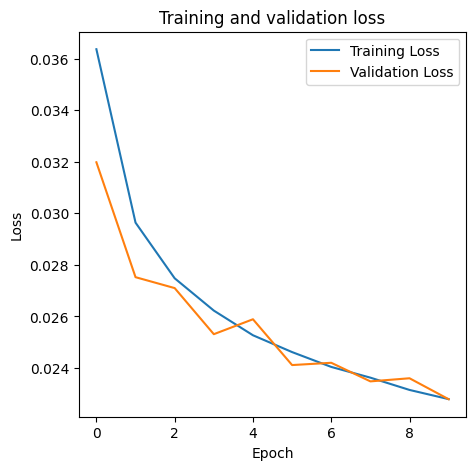

In [32]:
hf.analyze_trainings(trainings_list)

1/1 [==============================] - 1s 906ms/step


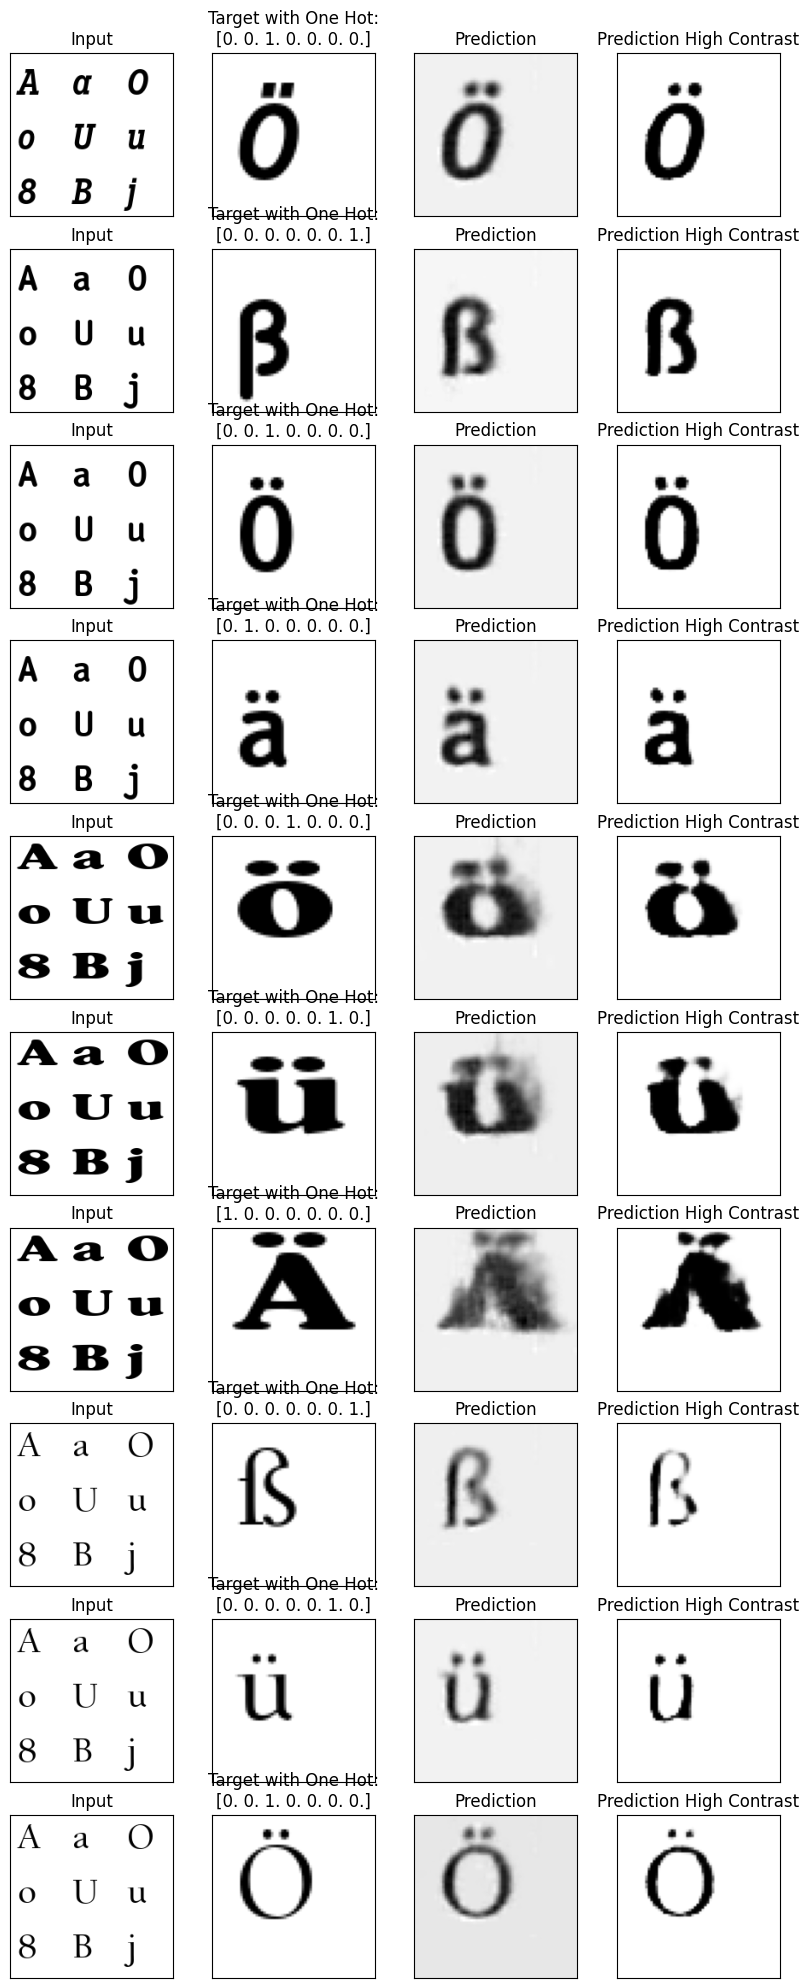

In [33]:
hf.render_predictions(model, test_dataset, 10, model_type="2dGrid-OneHot-SingleGlyph")

In [34]:
model.base_model.trainable = True

In [35]:
trainings_list.append({
    # getting all the keys and values from the training_parameters dict and adding them to the training dict
    **training_parameters,
    "history": model.fit(
        train_dataset,
        epochs=40,
        validation_data=test_dataset,
)})

Epoch 1/40


1799/1799 [==============================] - 86s 48ms/step - loss: 0.0225 - val_loss: 0.0227
Epoch 2/40
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0222 - val_loss: 0.0225
Epoch 3/40
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0219 - val_loss: 0.0221
Epoch 4/40
1799/1799 [==============================] - 87s 48ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 5/40
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0215 - val_loss: 0.0221
Epoch 6/40
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0212 - val_loss: 0.0223
Epoch 7/40
1799/1799 [==============================] - 86s 48ms/step - loss: 0.0211 - val_loss: 0.0218
Epoch 8/40
1799/1799 [==============================] - 85s 47ms/step - loss: 0.0209 - val_loss: 0.0222
Epoch 9/40
1799/1799 [==============================] - 85s 47ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 10/40
1799/1799 [==============================] - 85s 47ms/step - lo

###############################
Best training was the last one!
###############################
Best training was the last one!
###############################
Best training was the last one!
###############################

The summary of the model with the best val_loss during training:
Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 6, 6, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               23593472  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                          

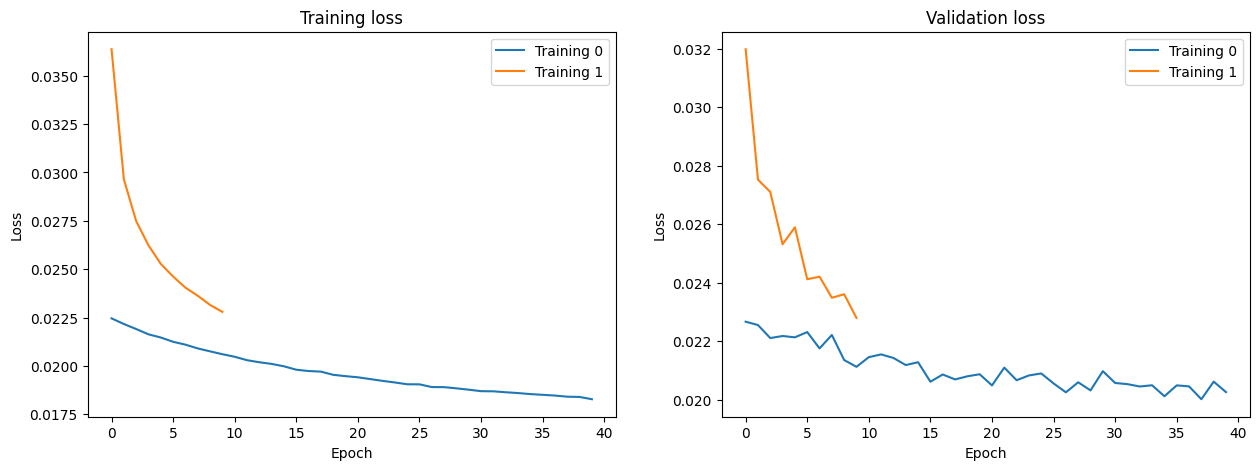

In [36]:
hf.analyze_trainings(trainings_list)

1/1 [==============================] - 0s 36ms/step


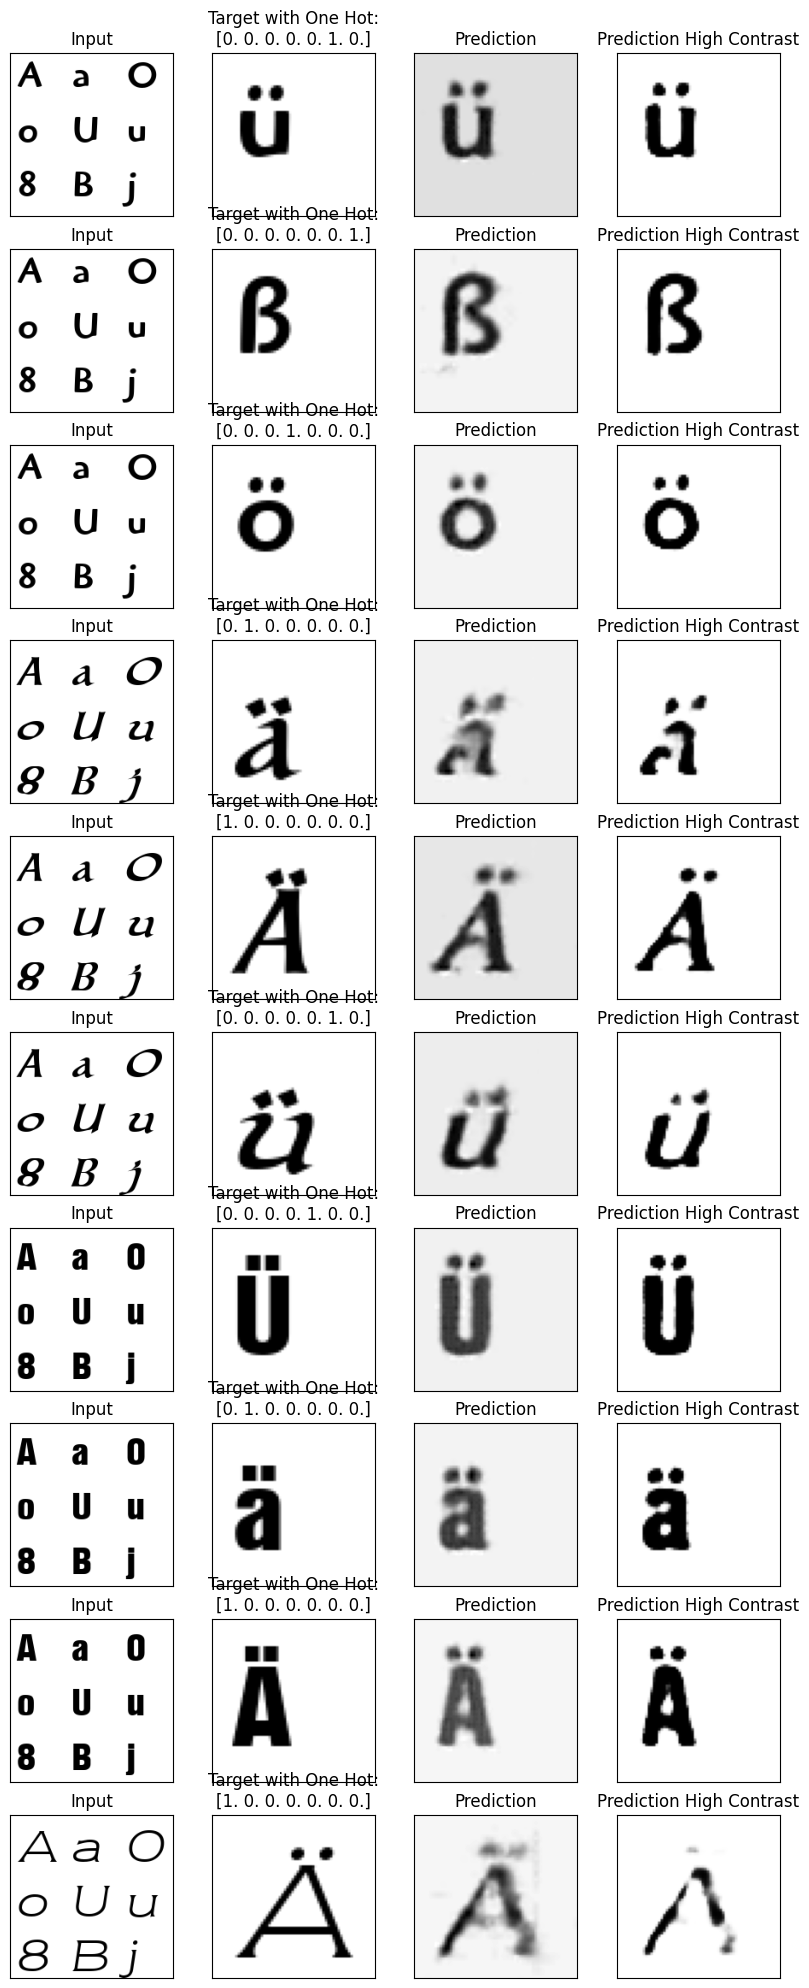

In [37]:
hf.render_predictions(model, test_dataset, 10, model_type="2dGrid-OneHot-SingleGlyph")

1/1 [==============================] - 0s 26ms/step


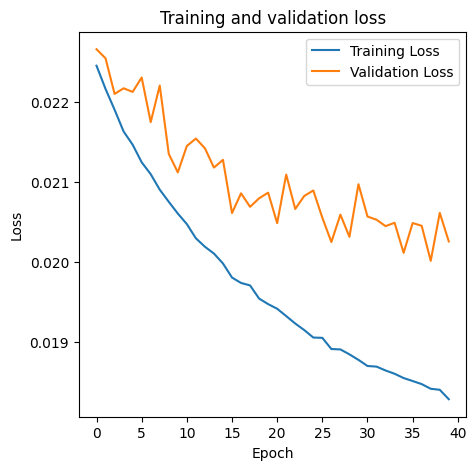

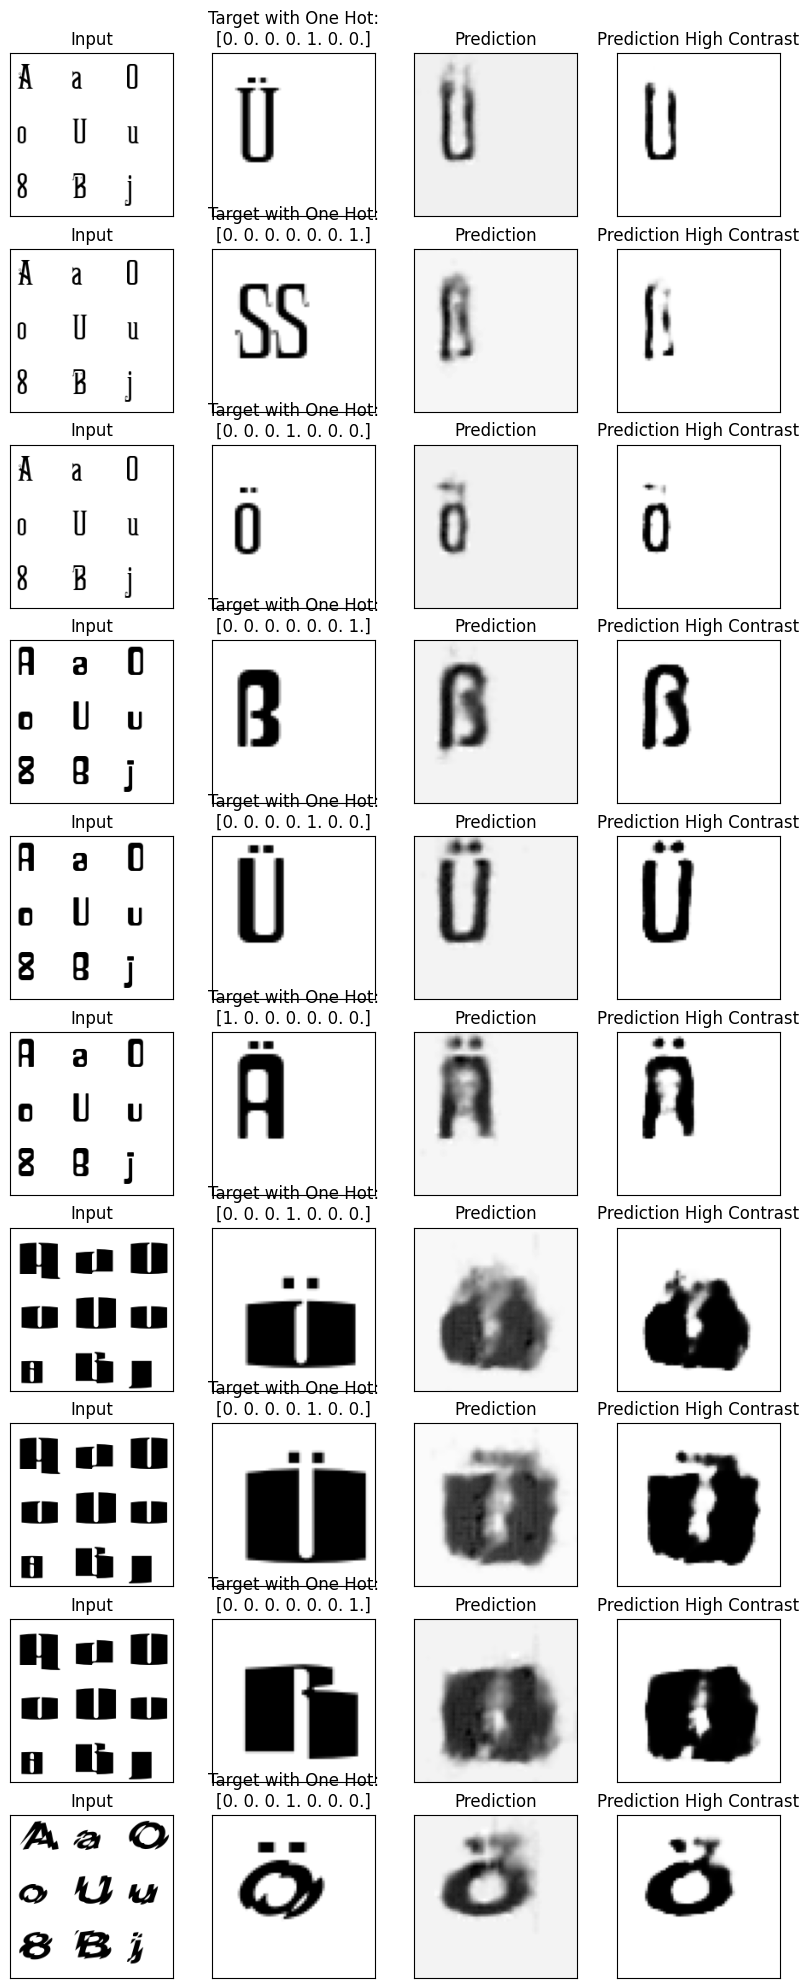

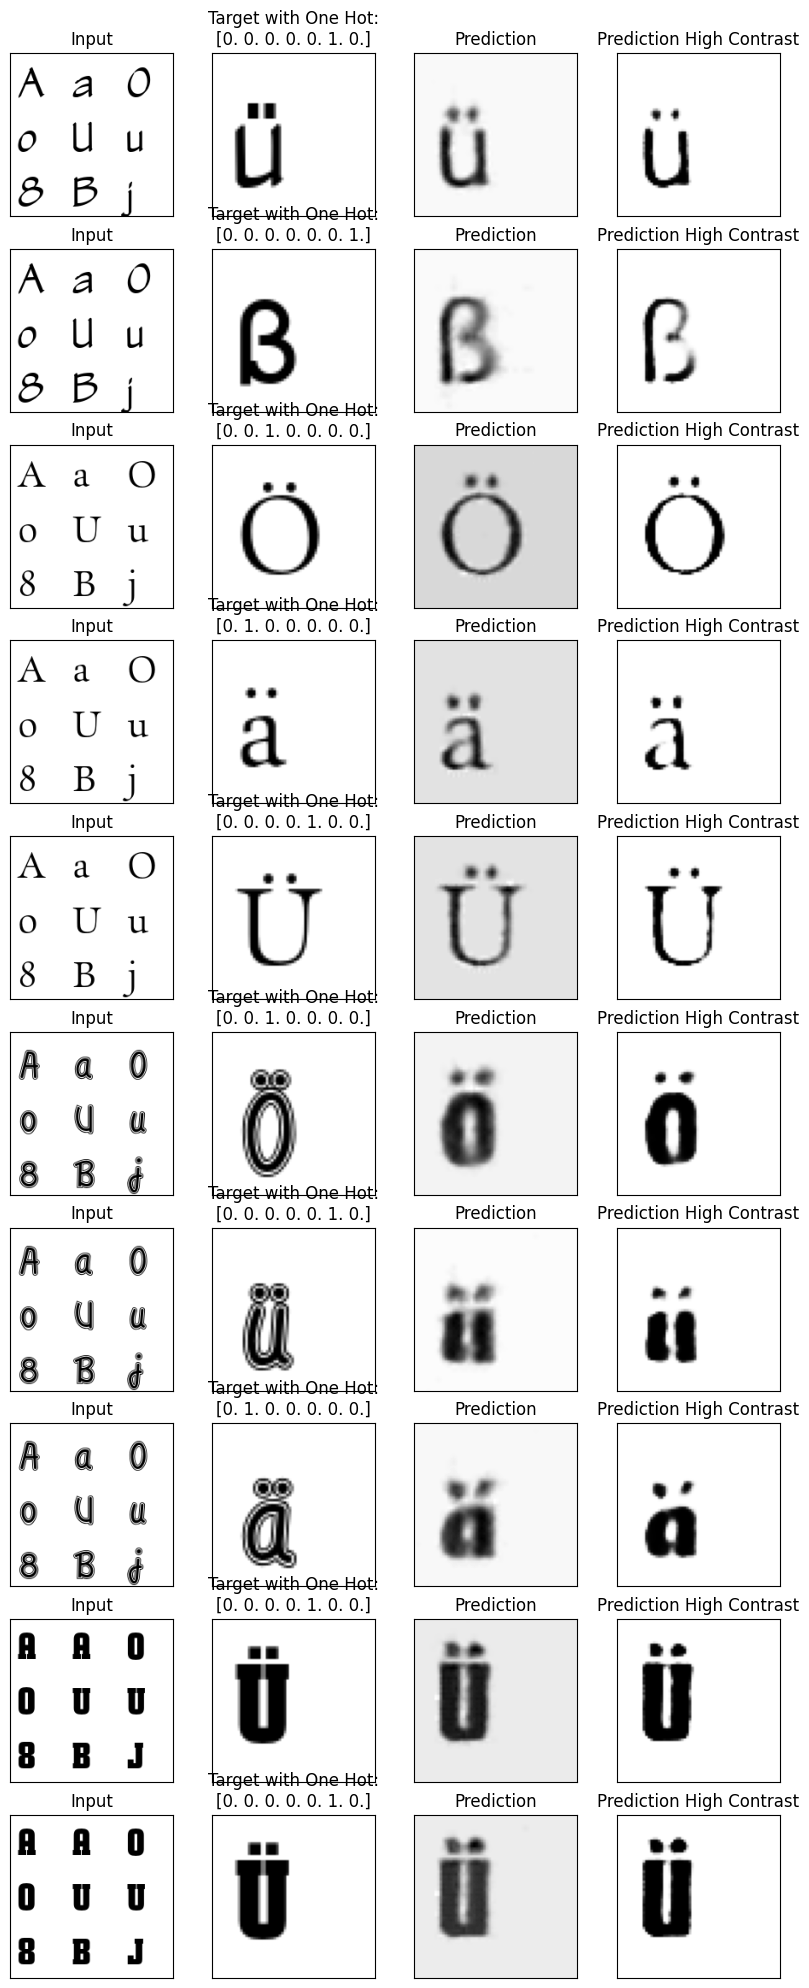

In [38]:
hf.save_summary_last_training(trainings_list, test_dataset, 
                              "../models/logs/", "../models/",
                              model_type="2dGrid-OneHot-SingleGlyph")